# Naive Attempt at Sentence Embedding, Clustering, and then Decoding Representations.

This file experiments with (1) creating a sentence-level embedding space with BERT embeddings based on *only* LLM responses, (2) basic k-mean clustering + labeling, (3) decoding/paraphrase methods of the cluster centroids back to understandable sentence representations.


Install/import necessary libraries. For now we will be using Sentence-BERT for sentence level embeddings (paper: https://arxiv.org/abs/1908.10084, documentation: https://www.sbert.net/) 
Since no venv is set up yet, run the following:

!pip install transformers torch

!pip install -U sentence-transformers

(Disclaimer: only these were really needed to work on my (Kerria's) PC, but it'll probably vary from env to env.)


In [9]:
from sentence_transformers import SentenceTransformer, util


C:\Users\Kerria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


### Basic Examples
Create Embedding Model and run basic example (right now, it's displaying a warning: "to support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator")

In [10]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# The sentences to encode
sentences = [
    "The weather is lovely today.",
    "It's so sunny outside!",
    "He drove to the stadium.",
]

# 2. Calculate embeddings by calling model.encode()
embeddings = embedding_model.encode(sentences)
print(embeddings.shape)
# [3, 384]

# 3. Calculate the embedding similarities
similarities = embedding_model.similarity(embeddings, embeddings) # similarity matrix, M[i][j] is how similar sentence i is to sentence j (should be symmetric), pretty sure this uses cosine similarity

C:\Users\Kerria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


(3, 384)


In [11]:
similarities

tensor([[1.0000, 0.6660, 0.1046],
        [0.6660, 1.0000, 0.1411],
        [0.1046, 0.1411, 1.0000]])

Direct inversion of an embedding to a sentence is impossible, but you can use paraphrasing/retrieval methods (but this would require some generative model). In this example, we'll put all the dataset sentences into some corpus, and then understandably represent a cluster centroid with the sentence(s) that are most close to the centroid's location in the embedding space.

Here's a basic example of it.

In [12]:
# corpus embeddings
corpus = ['This is a sentence.', 'BERT provides embeddings.', 'I like machine learning.']
corpus_embeddings = embedding_model.encode(corpus)

# query/reference embedding we are gonna find the most similar sentence in corpus to
query_embedding = embedding_model.encode('BERT helps with embeddings.')

# similarity scores
similarity_scores  = util.cos_sim(query_embedding, corpus_embeddings) # use util.cos_sim because format is in list not matrix

closest_sentence = corpus[similarity_scores.argmax()] # argm



In [13]:
closest_sentence 

'BERT provides embeddings.'

### Basic Clustering and Matching of Centroid representations (just answers)
Now let's do this with the clustering centroids of the ticket answers. For now, we will vectorize only LLM responses that are labeled as hallucinations. We will use k-means clustering and then identify the closest sentences to the centroids of each cluster. We will then be performing PCA and visualization of the clusters. Possible future directions include performing dimensionality reduction or re-defining dimensions on these centroid locations.

Dataset links: https://www.kaggle.com/competitions/ml-olympiad-detect-hallucinations-in-llms/data?select=train.csv, https://www.kaggle.com/datasets/suraj520/customer-support-ticket-dataset



In [76]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

In [88]:
df = pd.read_csv("../IMDB.csv")#"helpdesk_customer_tickets.csv")
text_col = "review"
label_col = 'sentiment'

just english for now

In [85]:
#df = df[df["language"] == "en"]

In [89]:
df =df.sample(frac=0.05)
len(df)

2500

In [90]:
df.columns

Index(['review', 'sentiment'], dtype='object')

In [91]:
llm_responses = df[text_col]#["answer"]

Embeddings of llm_responses

In [92]:
embeddings = embedding_model.encode(llm_responses.tolist(), convert_to_tensor=False)

## K-means Clustering

First cluster without PCA or any dimensionality reduction.

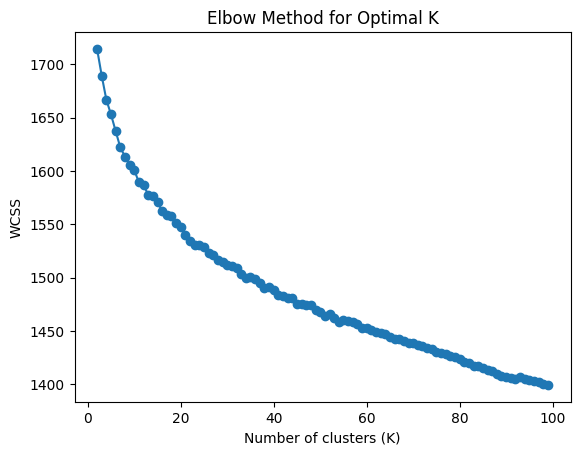

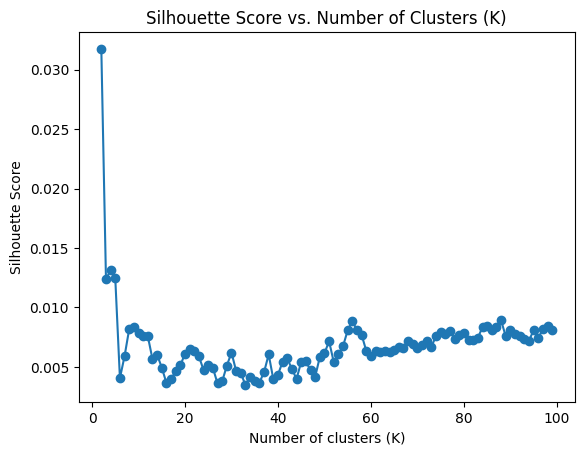

In [94]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
# determine good number of clusters
# Initialize variables
wcss = []
silhouette_scores = []
upper_bound_k = 100
# Calculate WCSS for each K
for k in range(2, upper_bound_k):  # Choosing range from 1 to 10 for demonstration
    # wcss
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(embeddings)  # Assuming X is your dataset
    wcss.append(kmeans.inertia_)
    
    labels = kmeans.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels)
    silhouette_scores.append(score)

# Plot the WCSS values
plt.plot(range(2, upper_bound_k), wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')
plt.show()

# Plot silhouette scores to find optimal K
plt.plot(range(2, upper_bound_k), silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters (K)')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

Choose number of clusters.

In [117]:
num_clusters = 5  # Define the number of clusters you want
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(embeddings)

In [118]:
df

,review,sentiment,cluster,cluster_small-e
28177,"Don't get me wrong, I love Stephen King! And t...",negative,0,0
23263,"Jack Frost 2. THE worst ""horror film"" I have e...",negative,1,8
26549,I wish I could have given this a Zero. Sure I'...,negative,1,9
22133,Ostensibly this is a Z-grade DTV horror film.<...,negative,1,8
17643,I got this movie from Netflix after a long wai...,positive,1,9
...,...,...,...,...
12192,"After the success of Star Wars, there was a bo...",negative,1,2
10639,This abomination and the sequel ONE MORE TIME ...,negative,1,5
29698,"Just like all of Mel Brooks' other comedies, M...",positive,4,9
37190,"Um, hello.. Rainbow Brite.. the name alone is ...",positive,3,7


Show examples from each cluster. I have not been able to identify clear commonalities for k=5,10, or 20. Many clusters appear to have a mix of positive and negative reviews. 

In [119]:
# looks like it clustered it by language, kind of a win?
print("Sentence Clustering:")
for i in range(num_clusters):
    print(f"\n\nCluster {i}:")
    samples = df[df["cluster"] == i][text_col].tolist()[:7]
    for s in samples:
        print("--")
        print(s)
    print("--")

Sentence Clustering:


Cluster 0:
--
Don't get me wrong, I love Stephen King! And this is a pretty good movie over all. The rabid Cujo is very scary and the movie is suspenseful. But after the first few minutes that poor Donna and her little son Tad were held captive in their Pinto by the rabid St. Bernard, I began to wonder why she didn't do something to help herself.<br /><br />She could have stuck her foot out the door and pushed the car backwards (I mean, it was a Pinto for Pete's sake and they were on a downhill incline) and rolled to safety, but then it would have been a very short movie. When she got the car started, did she pop it into reverse and hope that she could get at least get part way down the driveway? No, she tries to make a three point turn in a car with a bad alternator. She did manage to get out of the car and look around for 45 seconds or so at one point to try and get to a baseball bat that was lying on the ground nearby--what a waste of time! I mean, if you're g

PCA and visualization. Now let's visualize the clusters in 2 dimensions using PCA.

- cluster 0 = spanish

- cluster 1 = French

- cluster 2 = German

- cluster 3 = Portuguse

- Cluster 4 = English

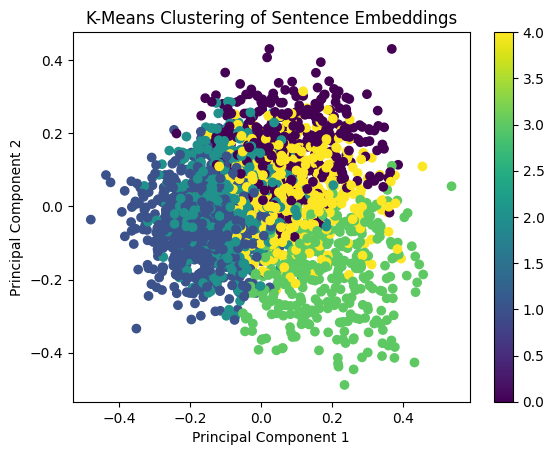

In [120]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plot the clusters
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df['cluster'], cmap='viridis')
plt.title('K-Means Clustering of Sentence Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

Calculate the within cluster sum of squares or inertia. This is the within-cluster sum of squares. (lower = more compact, higher = more spread). Should use "elbow method" to select number of clusters: as you increase k, when the WCSS stops decreasing choose that number of clusters (i.e., smallest number of clusters with smallest WCSS score).

In [121]:
wcss = kmeans.inertia_
print(wcss)

1649.575927734375


Decode/find closest examples to centroid centers. Right now we're just using cosine similarity, but I think there are ways to use generative models to create understandable representations of the sentence embeddings.

In [122]:
# get embedding vectors of centroids
centroid_embeddings = kmeans.cluster_centers_

def get_closest_sentence(query_embedding, corpus, corpus_embeddings):
    similarity_scores  = util.cos_sim(query_embedding, corpus_embeddings) 
    closest_sentence = corpus[similarity_scores.argmax()]
    return closest_sentence

In [123]:
corpus = list(df[text_col])
# corpus_embeddings = embedding_model.encode(corpus)

In [124]:
for i, centroid_vec in enumerate(centroid_embeddings):
    similarity_scores = util.cos_sim(centroid_vec, embeddings)
    closest_sentence = corpus[int(similarity_scores.argmax())]
    print(f"Center sentence of cluster {i}:\n-----\n{closest_sentence}\n-----\n\n")

Center sentence of cluster 0:
-----
i've heard a lot about the inventive camera-work and direction in this movie. i thought both were a mess<br /><br />also some truly terrible acting. the main 'heroine' in the movie is irritating beyond belief and has absolutely nothing useful to contribute in any situation. everything she does or says is stupid, and she generally just seems to mess peoples lives up. if she could fight, i might forgive her<br /><br />overall all the women in this movie are stereotypical 'broads' in need of a man to save them. and all the men in this movie are muscle bound dim wits capable of saving no one<br /><br />this is a poor movie, and i urge you to avoid it. watch something like 'the sword of doom' instead, i hear its much better than this confusing mess of a film.
-----


Center sentence of cluster 1:
-----
I get to the cinema every week or so, and regularly check out this site, but never before have I felt compelled to comment on a film.<br /><br />To my all 

## Incorporate decision trees for feature selection

"Shrink" or drop the non-important features w.r.t. the output you care about, and "Expand" the important ones, i.e., the ones whose values determines the output class.

In [125]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

# choose an output class we care about
output_class = 'sentiment'

X_train, X_test, y_train, y_test = train_test_split(embeddings, df[output_class], random_state = 8, test_size = 0.3)


Train the Decision tree, find dfeature importances

In [132]:
# Fit your decision tree model
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# Access feature importances
feature_importances = model.feature_importances_
print(feature_importances)

[0.         0.00578307 0.00171451 0.         0.         0.
 0.         0.         0.00171451 0.00672606 0.00209551 0.00226128
 0.         0.00641052 0.         0.01852765 0.0022047  0.
 0.         0.         0.00222585 0.00397298 0.         0.
 0.         0.         0.         0.         0.00182881 0.
 0.00114301 0.         0.         0.         0.00218662 0.
 0.         0.0046779  0.         0.         0.         0.
 0.         0.         0.01133851 0.         0.00195944 0.00503705
 0.         0.         0.         0.         0.         0.00798111
 0.00617379 0.         0.         0.00656069 0.0065164  0.00400744
 0.01173754 0.00433502 0.00386257 0.         0.00724015 0.
 0.00685804 0.         0.         0.         0.0039597  0.
 0.         0.         0.00635004 0.         0.         0.
 0.00920069 0.01643223 0.         0.         0.         0.
 0.         0.         0.         0.         0.00200026 0.
 0.         0.         0.00273728 0.         0.         0.00226033
 0.         0.  

In [130]:
# Calculate the accuracy BEFORE flooring
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy} for class amounts:\n {df[output_class].value_counts()}")

Accuracy: 0.612 for class amounts:
 sentiment
positive    1259
negative    1241
Name: count, dtype: int64


Get rid features indices that are 0.

In [146]:
import numpy as np
# Get indices of zero-importance features
zero_importance_indices = np.where(feature_importances < 0.025)[0] # random sampling prob. -- 1/384 = 0.0026

# delete those entries
embeddings_small = np.delete(embeddings, zero_importance_indices, axis=1)
X_train_reduced = np.delete(X_train, zero_importance_indices, axis=1)
X_test_reduced = np.delete(X_test, zero_importance_indices, axis=1)
print(f"embedding went from size {len(X_train[0])} to {len(X_train_reduced[0])}")

embedding went from size 384 to 4


Retrain classifier on just this. We have virtually the same probability with the a fraction of the features.

In [151]:
# Fit your decision tree model
model_small = DecisionTreeClassifier()
model_small.fit(X_train_reduced, y_train)

# Access feature importances
#feature_importances = model.feature_importances_

# Calculate the accuracy after deleting
y_pred_smaller = model_small.predict(X_test_reduced)
accuracy = accuracy_score(y_test, y_pred_smaller)
print(f"Accuracy: {accuracy} for class amounts:\n {df[output_class].value_counts()}")

Accuracy: 0.5786666666666667 for class amounts:
 sentiment
positive    1259
negative    1241
Name: count, dtype: int64


## Same clustering process but on only important features

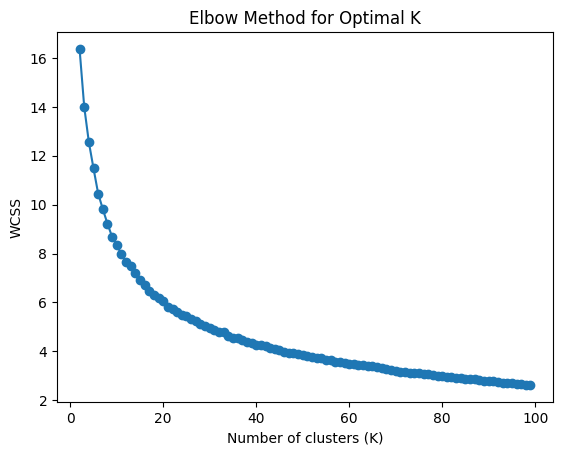

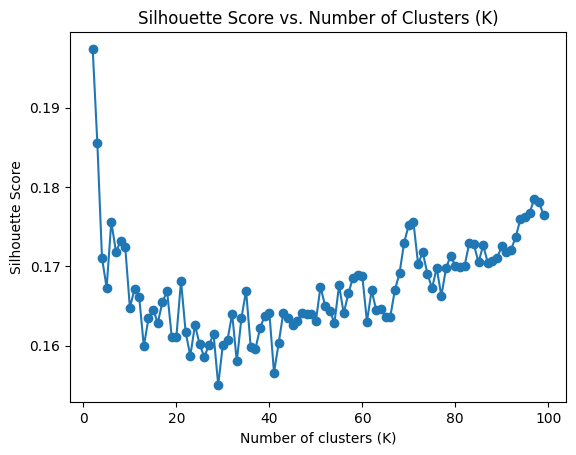

In [152]:
# determine numm clusters by WCSS and silhouette_score (needed for highly dimensional data)
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score


# Initialize variables
wcss = []
silhouette_scores = []
upper_bound_k = 100
# Calculate WCSS for each K
for k in range(2, upper_bound_k):  # Choosing range from 1 to 10 for demonstration
    # wcss
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(embeddings_small)  # Assuming X is your dataset
    wcss.append(kmeans.inertia_)
    
    labels = kmeans.fit_predict(embeddings_small)
    score = silhouette_score(embeddings_small, labels)
    silhouette_scores.append(score)

# Plot the WCSS values
plt.plot(range(2, upper_bound_k), wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')
plt.show()

# Plot silhouette scores to find optimal K
plt.plot(range(2, upper_bound_k), silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters (K)')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

There is still no clear minima, but the within-cluster sum of squares is overall noticeably smaller (1700 WCSS to 17 WCSS) and higher silhouette score.

In [157]:
num_clusters = 5  # Define the number of clusters you want
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster_small-e'] = kmeans.fit_predict(embeddings_small)

In [159]:
print("Sentence Clustering:")
for i in range(num_clusters):
    print(f"\n\n\nCluster {i}:")
    samples = df[df['cluster_small-e'] == i][text_col].tolist()[:5]
    for s in samples:
        print("--")
        print(s)
    print("--")

Sentence Clustering:



Cluster 0:
--
I am amazed at the amount of praise that is heaped on this movie by other commentators. To me it was rather a disappointment, especially the combination of historical facts, fantasy and the main character's internal turmoil does not work at all (in Vonnegut's book Slaughterhouse Five and even in George Roy Hill's adaptation for the screen it does). Credibility is often overstretched. Too many questions are left open. Did I miss some central points? Or did I fail to spot the lines that supposedly connect the dots? <br /><br />A boy called Campbell, Jr., grows up in upstate New York. At home his father has many technical trade papers and one book. It has photographs of heaps of dead bodies in it. The boy leafs through the book, his dad doesn't like his doing that. What should this tell me? The family moves away from upstate New York to Berlin. BANG. It is 1938, the boy is a married man in Berlin and a theater playwright. What kind of plays does he wr

PCA visualization.

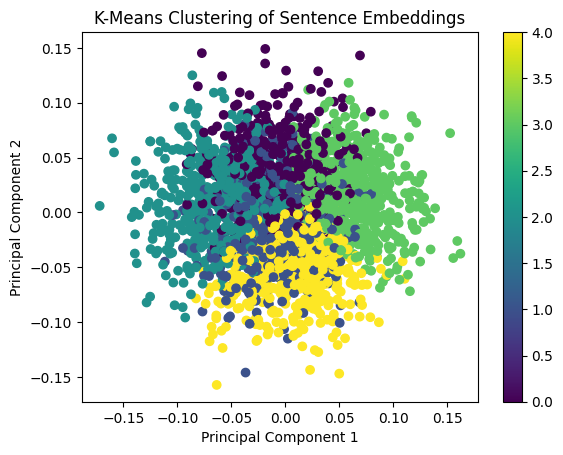

In [160]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_small)

# Plot the clusters
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df['cluster_small-e'], cmap='viridis')
plt.title('K-Means Clustering of Sentence Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()